In [1]:
import re
import json
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns

# NLTK Stop words
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# spacy for lemmatization
import spacy

#remove urls, mentions, emojis 
import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [2]:
filepath = '/Users/lavine/Desktop/Terriers!/misinformation project/data/data.txt'

### Create a dataframe for the first dictionary (failed right now)

Take a look at our dirst dictionary

In [3]:
df_0_json = pd.read_json(filepath, lines=True, nrows=1)

In [4]:
df_0_json['lang']

0    und
Name: lang, dtype: object

In [5]:
df_0_json

,lang,id,possibly_sensitive,author_id,text,referenced_tweets,created_at,source,entities,in_reply_to_user_id,reply_settings,conversation_id,public_metrics,author,in_reply_to_user,__twarc
0,und,1477065589361315840,False,1460383957262880768,@tjbabel @Catherine_LCP @SamBoik @Cernovich ht...,"[{'type': 'replied_to', 'id': '147706468563978...",2021-12-31 23:54:13+00:00,Twitter for iPhone,"{'urls': [{'start': 44, 'end': 67, 'url': 'htt...",1733391854,everyone,1476711967607853056,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'verified': False, 'created_at': '2021-11-15T...","{'verified': False, 'created_at': '2013-09-05T...",{'url': 'https://api.twitter.com/2/tweets/sear...


### Create a dataframe by every columns

In [6]:
#load all the JSON objects in one list as dictionaries
data = []
with open(filepath,'r') as f:
    for line in f:
        data.append(json.loads(line))

In [7]:
data[9]['text']

'\'We are in a climate emergency\'December wildfires ravage Colorado https://t.co/sWDkZM4Rvn Sen. Manchin, your Exxon highway bill isn\'t going 2save our homes or our lives," "Your greed &amp; corruption is not only torching our future It\'s burning our communities and destroying lives!'

In [8]:
data[4]['referenced_tweets'][0]['text']

'@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3'

 #### Put the text data in one list

In [9]:
#retrive text and avoid truncated text when retweet without quoting
lst_text = []
for i in data:    
    if 'referenced_tweets' in i:
        if i['referenced_tweets'][0]['type'] == 'retweeted':
            lst_text.append(i['referenced_tweets'][0]['text'])
        else:
            lst_text.append(i['text'])
    else:
        lst_text.append(i['text'])

In [10]:
lst_text[:2]

['@tjbabel @Catherine_LCP @SamBoik @Cernovich https://t.co/a5p9XOE7b9',
 '@tjbabel @Catherine_LCP @SamBoik @Cernovich https://t.co/BRBvadbSVr']

 #### Put the author info in list

In [11]:
data[0].keys()

dict_keys(['lang', 'id', 'possibly_sensitive', 'author_id', 'text', 'referenced_tweets', 'created_at', 'source', 'entities', 'in_reply_to_user_id', 'reply_settings', 'conversation_id', 'public_metrics', 'author', 'in_reply_to_user', '__twarc'])

 ##### 'id', 'author_id', 'conversation_id', 'author'

In [12]:
#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []
for i in data:
    lst_id.append(i['id'])
    lst_lang.append(i['lang'])
    lst_author_id.append(i['author_id'])
    lst_conversation_id.append(i['conversation_id'])

There are too much info in author dictionary

In [81]:
data[0]

{'lang': 'und',
 'id': '1477065589361315842',
 'possibly_sensitive': False,
 'author_id': '1460383957262880776',
 'text': '@tjbabel @Catherine_LCP @SamBoik @Cernovich https://t.co/a5p9XOE7b9',
 'referenced_tweets': [{'type': 'replied_to',
   'id': '1477064685639782404',
   'lang': 'en',
   'possibly_sensitive': False,
   'author_id': '1733391854',
   'text': '@owen_lavine @Catherine_LCP @SamBoik @Cernovich Ever heard of the carbon cycle? Google it.',
   'entities': {'annotations': [{'start': 80,
      'end': 85,
      'probability': 0.4095,
      'type': 'Organization',
      'normalized_text': 'Google'}],
    'mentions': [{'start': 0,
      'end': 12,
      'username': 'owen_lavine',
      'id': '1460383957262880776',
      'verified': False,
      'created_at': '2021-11-15T23:07:29.000Z',
      'public_metrics': {'followers_count': 12,
       'following_count': 245,
       'tweet_count': 963,
       'listed_count': 0},
      'name': 'Owen Lavine',
      'description': 'Journalist - C

In [14]:
#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []
for i in data:
    lst_author_verified.append(i['author']['verified'])
    lst_author_name.append(i['author']['name'])
    lst_author_username.append(i['author']['username'])

 ##### Make creation time

In [15]:
#list creation time
lst_twt_creation_time = []
for i in data:
    lst_twt_creation_time.append(i['created_at'])

##### Put what we have in one dataframe

lst_text,lst_id, lst_author_id,lst_conversation_id,lst_author_verified, lst_author_name, lst_author_username,lst_twt_creation_time

In [16]:
tweets = pd.DataFrame({'text': lst_text,
                  'language': lst_lang,
                  'id': lst_id,
                  'author_id': lst_author_id,
                  'conversation_id': lst_conversation_id,
                  'author_verified': lst_author_verified,
                  'author_name': lst_author_name,
                  'author_username': lst_author_username,
                  'twt_creation_time': lst_twt_creation_time
                  })

In [88]:
pd.set_option("display.max_colwidth", 10000)

In [18]:
tweets.drop(tweets[tweets['language'] != 'en'].index, inplace = True)

In [89]:
tweets.head()

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext
2,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477059914015125507,2732778706,1477059914015125507,False,Tai Chi,TaiWendysb,2021-12-31T23:31:40.000Z,[],"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose."
3,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477056800889323523,414239235,1477056800889323523,False,Richard Estes,oshima9,2021-12-31T23:19:18.000Z,[],"no, capitalists are the cause."
4,@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3,en,1477046502400868359,824946672673361920,1477046502400868359,False,Kris,writing_callous,2021-12-31T22:38:23.000Z,[],We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s. Apparently global warming is too specific and scary. But Its global warming.
5,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477040827503362057,2429328178,1477040827503362057,False,David💙l🇪🇺#FindMissyandBiscuit,David96212152,2021-12-31T22:15:50.000Z,[],"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose."
6,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477035647462363141,795750344970141701,1476641658636693513,False,☭🇵🇸🇾🇪🇸🇾,zia_kat,2021-12-31T21:55:15.000Z,[],"no, capitalists are the cause."


### data preprocessing

In [20]:
tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [21]:
#forming a separate feature for cleaned tweets
tweets['ctext'] = tweets['text'].apply(lambda x: p.clean(x))

In [22]:
tweets.head(3)

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext
2,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477059914015125507,2732778706,1477059914015125507,False,Tai Chi,TaiWendysb,2021-12-31T23:31:40.000Z,[],"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose."
3,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477056800889323523,414239235,1477056800889323523,False,Richard Estes,oshima9,2021-12-31T23:19:18.000Z,[],"no, capitalists are the cause."
4,@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3,en,1477046502400868359,824946672673361920,1477046502400868359,False,Kris,writing_callous,2021-12-31T22:38:23.000Z,[],We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s. Apparently global warming is too specific and scary. But Its global warming.


In [23]:
#convert to list
ctext = tweets['ctext'].tolist()

In [24]:
# Remove new line characters
ctext = [re.sub('\s+', ' ', sent) for sent in ctext]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_91949/1351202947.py:2: DeprecationWarning: invalid escape sequence \s
  ctext = [re.sub('\s+', ' ', sent) for sent in ctext]


In [25]:
# Remove distracting single quotes
ctext = [re.sub("\'", "", sent) for sent in ctext]

In [26]:
# remove punctuations
ctext = [re.sub(r'[^\w\s]', '', sent) for sent in ctext]

In [27]:
ctext[1:5]

['no capitalists are the cause',
 'We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s Apparently global warming is too specific and scary But Its global warming',
 'Im thinking about writing a satire where the US Congress is blocked from taking action on the climate by a Senator who owns a coal company lives on a yacht and speaks daily with Exxon lobbyists  but Im worried people will think its too on the nose',
 'no capitalists are the cause']

### Tokenize words and further clean up text

In [28]:
#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altoghter

In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tweet_words = list(sent_to_words(ctext))

print(tweet_words[:1])

[['im', 'thinking', 'about', 'writing', 'satire', 'where', 'the', 'us', 'congress', 'is', 'blocked', 'from', 'taking', 'action', 'on', 'the', 'climate', 'by', 'senator', 'who', 'owns', 'coal', 'company', 'lives', 'on', 'yacht', 'and', 'speaks', 'daily', 'with', 'exxon', 'lobbyists', 'but', 'im', 'worried', 'people', 'will', 'think', 'its', 'too', 'on', 'the', 'nose']]


In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tweet_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tweet_words[0]]])

['im', 'thinking', 'about_writing_satire', 'where', 'the', 'us', 'congress', 'is', 'blocked', 'from', 'taking', 'action', 'on', 'the', 'climate', 'by', 'senator', 'who', 'owns', 'coal', 'company', 'lives', 'on', 'yacht', 'and', 'speaks', 'daily', 'with', 'exxon', 'lobbyists', 'but', 'im', 'worried', 'people', 'will', 'think', 'its', 'too', 'on', 'the', 'nose']


### Remove Stopwords, Make Bigrams and Lemmatize

In [67]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'm'])

In [68]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [69]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [70]:
# Remove Stop Words
tweet_words_nostops = remove_stopwords(tweet_words)

In [71]:
# Form Bigrams
tweet_words_bigrams = make_bigrams(tweet_words_nostops)

In [72]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])# not "en" any more

# Do lemmatization keeping only noun, adj, vb, adv
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tweet_lemmatized[:1])

[['m', 'think', 'block', 'take', 'action', 'senator', 'own', 'coal', 'company', 'live', 'yacht', 'speak', 'daily', 'lobbyist', 'm', 'worried', 'people', 'think', 'nose']]


### Creat the dictionary and the corpus

In [73]:
# Create Dictionary
id2word = corpora.Dictionary(tweet_lemmatized)

# Create Corpus
texts = tweet_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] ##### ?????

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown below is a mapping of (word_id, word_frequency(times of occurance)).

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1)]]


In [74]:
id2word[40]

'petroleum'

In [75]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[4]

#in put of LDA

'daily'

In [76]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('action', 1),
  ('block', 1),
  ('coal', 1),
  ('company', 1),
  ('daily', 1),
  ('live', 1),
  ('lobbyist', 1),
  ('m', 2),
  ('nose', 1),
  ('own', 1),
  ('people', 1),
  ('senator', 1),
  ('speak', 1),
  ('take', 1),
  ('think', 2),
  ('worried', 1),
  ('yacht', 1)]]

### Building the Topic Model

In [77]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [78]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.084*"go" + 0.053*"lose" + 0.051*"week" + 0.035*"point" + 0.034*"lower" + '
  '0.032*"broad_question" + 0.027*"kill" + 0.023*"order" + 0.023*"ability" + '
  '0.023*"regulate"'),
 (1,
  '0.052*"know" + 0.031*"exxon" + 0.020*"investment" + 0.019*"emission" + '
  '0.019*"show" + 0.016*"year" + 0.016*"rise" + 0.016*"commit" + '
  '0.015*"strategy" + 0.015*"yearly"'),
 (2,
  '0.220*"company" + 0.061*"involve" + 0.059*"hear" + 0.058*"recuse" + '
  '0.054*"stricter_ethic" + 0.054*"amy_coney" + 0.048*"previous" + '
  '0.025*"capture" + 0.020*"environmental" + 0.019*"science"'),
 (3,
  '0.040*"oil" + 0.023*"case" + 0.022*"big" + 0.016*"fund" + 0.015*"amp" + '
  '0.014*"job" + 0.014*"fuel" + 0.013*"large" + 0.012*"law" + '
  '0.012*"emission"')]


### Compute model perplexity and coherence score

In [79]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.170035116126085

Coherence Score:  0.26628529500205533


In [80]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.180466 -0.070561       1        1  39.877002
1      0.261750 -0.091714       2        1  37.403549
0     -0.337824 -0.229962       3        1  12.012374
2     -0.104392  0.392237       4        1  10.707075, topic_info=                     Term          Freq         Total Category  logprob  \
3                 company  89148.000000  89148.000000  Default  30.0000   
51                     go  37800.000000  37800.000000  Default  29.0000   
79                   know  72607.000000  72607.000000  Default  28.0000   
1790              involve  38960.000000  38960.000000  Default  27.0000   
900                  hear  23717.000000  23717.000000  Default  26.0000   
...                   ...           ...           ...      ...      ...   
17146  crisisanother_sign   3776.347517   4163.705141   Topic4  -4.6657   
9490                 reel   3738.761184   4153.526549   Topic4  -4.6757   
3032            ambitious   4408.288829   5234.074088   Topic4  -4.5110   
1790              involve  24389.929135  38960.297944   Topic4  -2.8003   
437               support   3139.241442   6964.718838   Topic4  -4.8505   

       loglift  
3      30.0000  
51     29.0000  
79     28.0000  
1790   27.0000  
900    26.0000  
...        ...  
17146   2.1366  
9490    2.1291  
3032    2.0626  
1790    1.7659  
437     1.4374  

[232 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
3105       1  0.000194         ability
3105       2  0.000194         ability
3105       3  0.999679         ability
0          2  0.999738          action
0          3  0.000123          action
...      ...       ...             ...
484        3  0.000048          yearly
2312       1  0.999323       yesterday
2312       3  0.000289       yesterday
17731      1  0.999450  young_engineer
17731      3  0.000244  young_engineer

[537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

### find the optimal number of topics

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [65]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_lemmatized, start=2, limit=4, step=1)

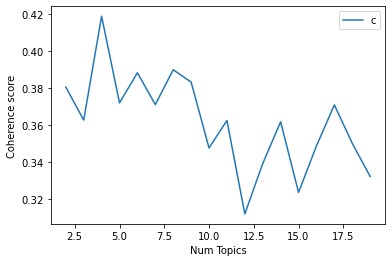

In [66]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3276
Num Topics = 4  has Coherence Value of 0.4217
Num Topics = 6  has Coherence Value of 0.3506
Num Topics = 8  has Coherence Value of 0.3606
